In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
from astroquery.vizier import Vizier
import subprocess

In [2]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('source-extractor', 'sex'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

source-extractor is installed properly as sex. OK
psfex is installed properly as psfex. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.


# 20230525184701-216-RA.wcs.proc.fits

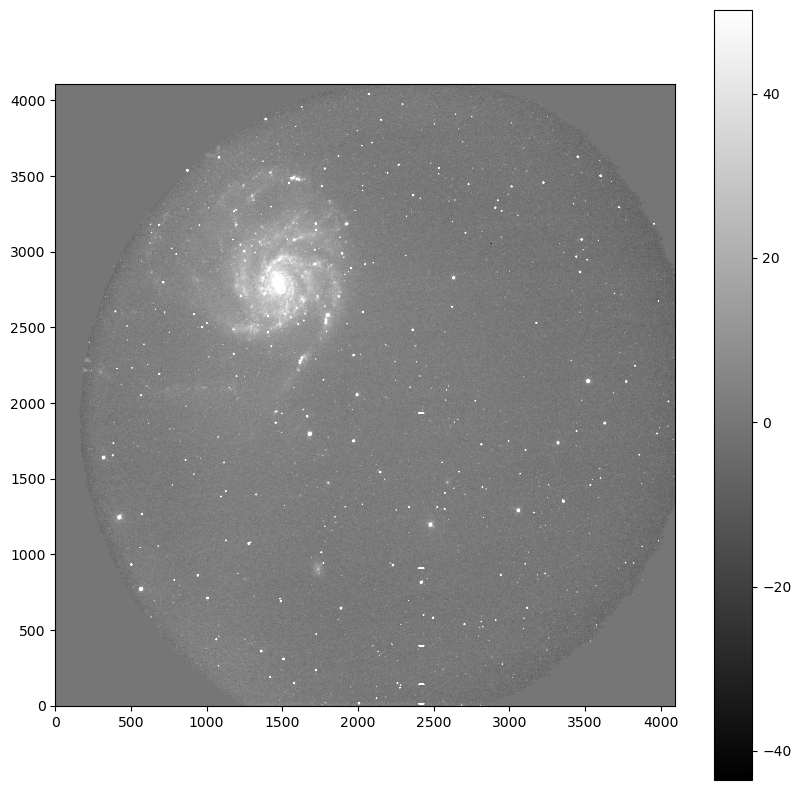

In [3]:
# os.chdir('/home/welcome/KSP/photometry/files_TASK_2')
imageName = '20230525184701-216-RA.wcs.proc.fits'

with fits.open(imageName) as HDUList:
    header = HDUList[0].header
    image = HDUList[0].data

zscale = ZScaleInterval().get_limits(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray', origin='lower', vmin=zscale[0], vmax=zscale[1])
plt.colorbar()
plt.show()

In [4]:
w = WCS(header)
(raImage, decImage) = w.all_pix2world(image.shape[0]/2, image.shape[1]/2, 1)
boxsize = 30 # arcminutes
maxmag = 18

catNum = 'II/349'
print(f'\nQuerying Vizier {catNum} around RA {raImage:.4f}, Dec {decImage:.4f} with a radius of {boxsize} arcmin')

try:
    # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":f"<{maxmag}", "Nd":">6", "e_gmag":f"<{1.086/3}"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=str(boxsize)+'m', catalog=catNum, cache=False)
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')


Querying Vizier II/349 around RA 211.1014, Dec 54.3133 with a radius of 30 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
210.663724090  53.919290610 172702106637313866 ... 16.4559  0.0164 115000
210.663539540  53.892741500 172672106635471999 ... 16.3082  0.0166 115000
210.604486980  53.926405740 172712106044792397 ... 16.4376  0.0142 115000
210.625757450  53.949266840 172732106257949830 ... 13.8435  0.0035 115000
210.559704780  53.937696580 172722105596905934 ... 15.5672  0.0071 115000
210.439170920  54.003287860 172802104391914650 ... 14.9887  0.0043 115000
210.447712130  54.046944570 172852104477077040 ... 14.0260  0.0031 115000
210.394009680  54.069378840 172882103939893987 ... 15.2874  0.0041 115000
210.377594030  54.093628720 172912103775753110 ... 13.8098  0.0052 115000
211.551848240  53.914855810 1

In [5]:
Q[0].meta['desc'] = Q[0].meta.pop('description')
Q[0].write('ps1Catalog.fits', format='fits', overwrite=True)

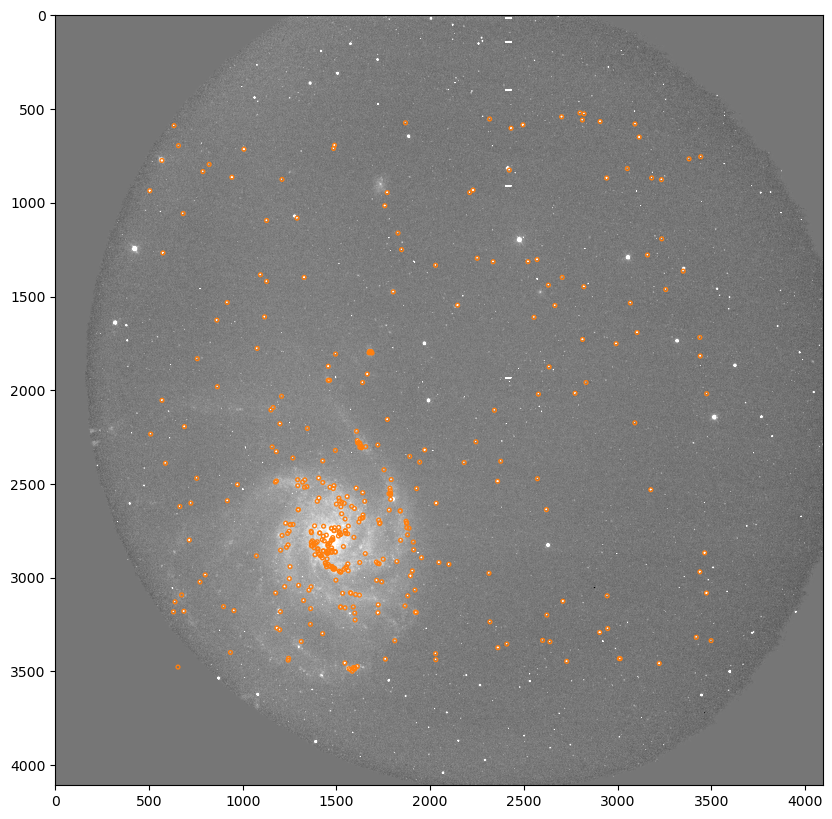

In [6]:
ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 10, edgecolor='C1', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

In [7]:
configFile = 'photomCat.sex'
catalogName = imageName + '.cat'
paramName = 'photomCat.param'
try:
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {catalogName} -PARAMETERS_NAME {paramName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230525184701-216-RA.wcs.proc.fits -CATALOG_NAME 20230525184701-216-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2024-06-24 at 21:29:05 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525184701-216-RA.wcs.proc.fits
----- Measuring from: 20230525184701-216-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 0          RMS: 11.3107    / Threshold: 113.107    
> Scanning image
> Line:   25  Objects:        4 detected /        0 sextracted
> Line:   50  Objects:        4 detected /        0 sextracted
> Line:   75  Objects:        5 detected /        0 sextracted
> Line:  100

In [8]:
with fits.open(catalogName) as HDU:
    print(HDU.info())
    sourceTable = Table(HDU[2].data)

print(sourceTable.colnames)
print(sourceTable)

cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) & (sourceTable['YWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']>500)]

Filename: 20230525184701-216-RA.wcs.proc.fits.cat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [19040A]   
  2  LDAC_OBJECTS    1 BinTableHDU    106   374R x 25C   [729E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 10E, 10E, 10E, 10E]   
None
['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
          VIGNET           X_IMAGE  ...          MAGERR_APER         
------------------------- --------- ... -----------------------------
     9.027542 .. 8.841557 2005.6249 ...  0.0022592018 .. 0.0034159245
  11.043878 .. -10.598225 2417.4963 ... 0.00

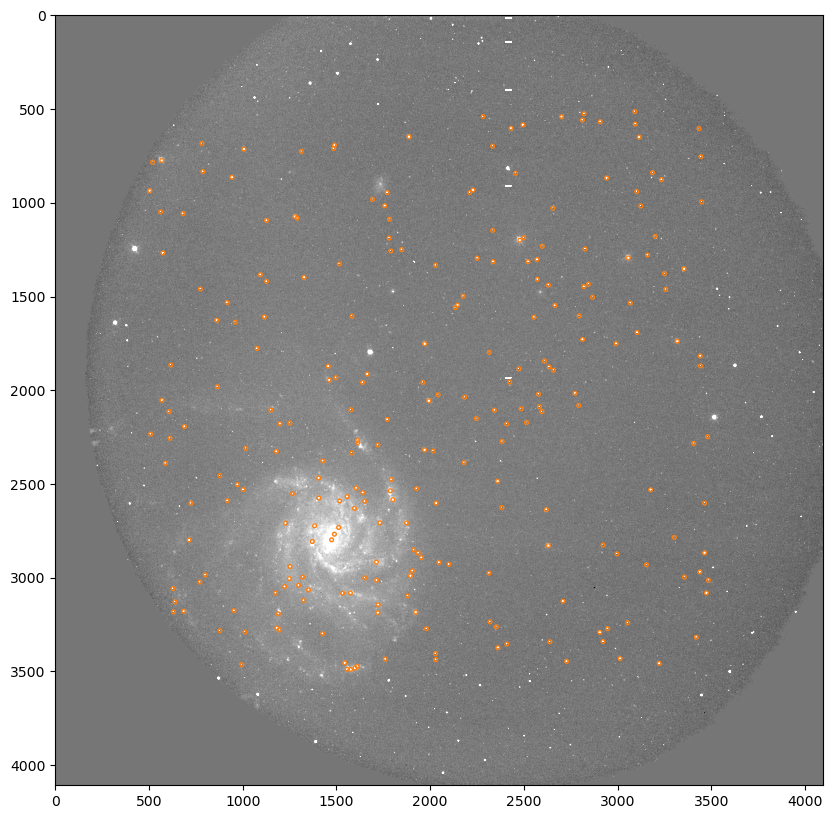

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 10, edgecolor='C1', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)
plt.show()

In [10]:
psfConfigFile = 'psfex_conf.psfex'

try:
    command = f'psfex -c {psfConfigFile} {catalogName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run psfex with exit error {err}')

Executing command: psfex -c psfex_conf.psfex 20230525184701-216-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



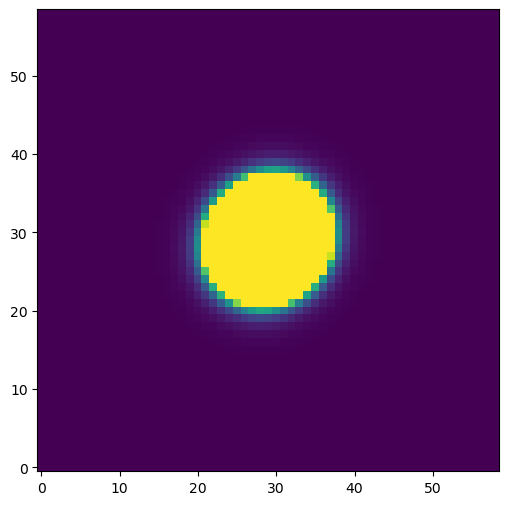

In [11]:
psfModelHDU = fits.open('moffat_' + imageName + '.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)

plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std, origin='lower')
plt.show()

In [12]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' # This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
try:
    # We are supplying SExtactor with the PSF model with the PSF_NAME option
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {psfcatalogName} -PSF_NAME {psfName} -PARAMETERS_NAME {psfparamName}'
    print(f"Executing command: {command}")
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230525184701-216-RA.wcs.proc.fits -CATALOG_NAME 20230525184701-216-RA.wcs.proc.fits.psf.cat -PSF_NAME 20230525184701-216-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2024-06-24 at 21:30:38 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525184701-216-RA.wcs.proc.fits
----- Measuring from: 20230525184701-216-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 0          RMS: 11.3107    / Threshold: 113.107    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextr

In [13]:
with fits.open(psfcatalogName) as HDU:
    psfsourceTable = Table(HDU[2].data)

print(psfsourceTable.colnames)
print(psfsourceTable)

cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
          VIGNET           X_IMAGE  ... FLUXRATIOERR_POINTSOURCE
------------------------- --------- ... ------------------------
     9.027542 .. 8.841557 2005.6249 ...                      0.0
  11.043878 .. -10.598225 2417.4963 ...                      0.0
      -1e+30 .. 11.050509 2682.6013 ...                      0.0
     -1e+30 .. -2.6355648 2808.9973 ...                      0.0
  -1.7916907 .. 18.164097 2121.4253 ...                      0.0
    2.359653 .. 0.2291578 1819.9691 ...                 

Found 142 good cross-matches


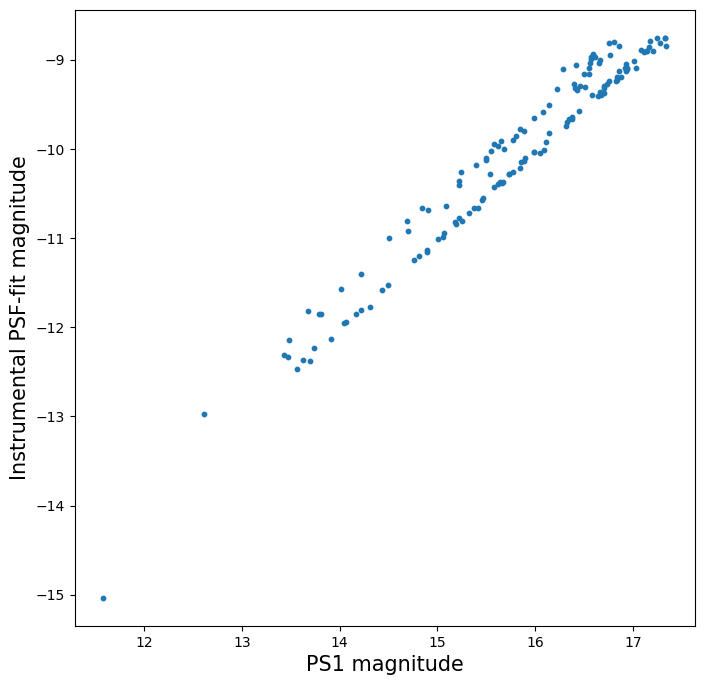

In [14]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print(f'Found {len(idx_psfimage)} good cross-matches')

plt.figure(figsize=(8,8))
plt.scatter(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage], color='C0', s=10)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

In [15]:
psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

ra = 210.910674637
dec = 54.3116510708

sn2023ixf_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_sn2023ixf, idx_cleanpsf_sn2023ixf, d2d, d3d = psfsourceCatCoords.search_around_sky(sn2023ixf_coords, photoDistThresh*u.arcsec)
print(f'Found the source at index {idx_cleanpsf_sn2023ixf[0]}')

PSF Mean ZP: 25.88
PSF Median ZP: 26.00
PSF STD ZP: 0.22
Found the source at index 153


/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [16]:
sn2023ixf_psfinstmag = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAG_POINTSOURCE'][0]
sn2023ixf_psfinstmagerr = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAGERR_POINTSOURCE'][0]

sn2023ixf_psfmag = zero_psfmed + sn2023ixf_psfinstmag
sn2023ixf_psfmagerr = np.sqrt(sn2023ixf_psfinstmagerr**2 + zero_psfstd**2)

print(f'PSF-fit magnitude of SN2023ixf is {sn2023ixf_psfmag} +/- {sn2023ixf_psfmagerr}')

PSF-fit magnitude of SN2023ixf is 11.038978488922119 +/- 0.21764998526536458


# 20230525190514-248-RA.wcs.proc.fits

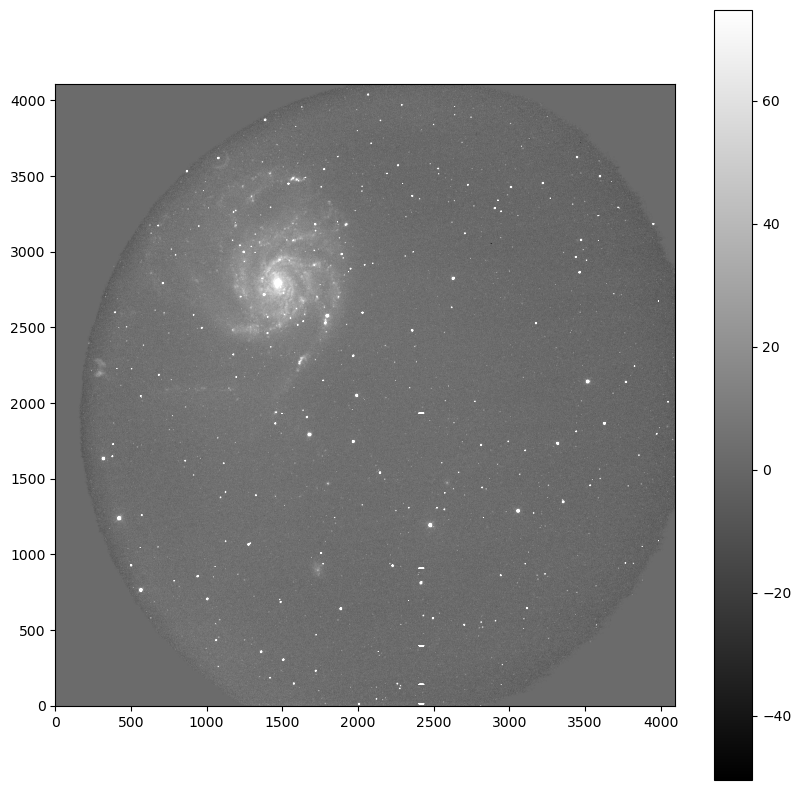

In [17]:
# os.chdir('/home/welcome/KSP/photometry/files_TASK_2')
imageName = '20230525190514-248-RA.wcs.proc.fits'

with fits.open(imageName) as HDUList:
    header = HDUList[0].header
    image = HDUList[0].data

zscale = ZScaleInterval().get_limits(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray', origin='lower', vmin=zscale[0], vmax=zscale[1])
plt.colorbar()
plt.show()


Querying Vizier II/349 around RA 211.1006, Dec 54.3126 with a radius of 30 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
210.729459870  53.862978240 172632107294506278 ... 15.1832  0.0043 115000
210.663724090  53.919290610 172702106637313866 ... 16.4559  0.0164 115000
210.663539540  53.892741500 172672106635471999 ... 16.3082  0.0166 115000
210.604486980  53.926405740 172712106044792397 ... 16.4376  0.0142 115000
210.625757450  53.949266840 172732106257949830 ... 13.8435  0.0035 115000
210.559704780  53.937696580 172722105596905934 ... 15.5672  0.0071 115000
210.439170920  54.003287860 172802104391914650 ... 14.9887  0.0043 115000
210.447712130  54.046944570 172852104477077040 ... 14.0260  0.0031 115000
210.394009680  54.069378840 172882103939893987 ... 15.2874  0.0041 115000
210.377594030  54.093628720 1

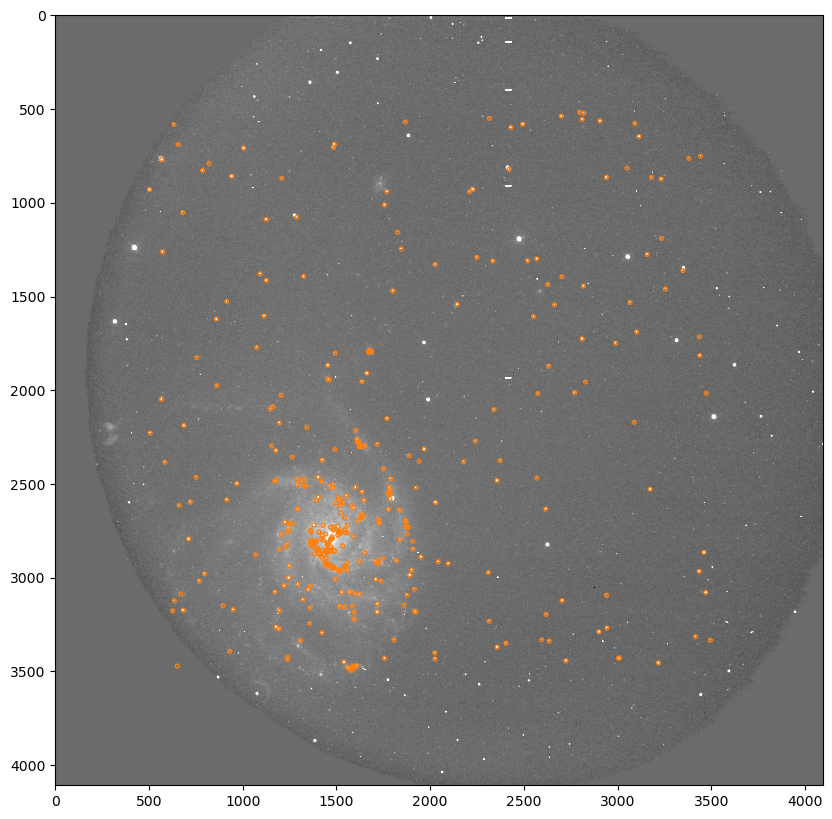

In [18]:
w = WCS(header)
(raImage, decImage) = w.all_pix2world(image.shape[0]/2, image.shape[1]/2, 1)
boxsize = 30 # arcminutes
maxmag = 18

catNum = 'II/349'
print(f'\nQuerying Vizier {catNum} around RA {raImage:.4f}, Dec {decImage:.4f} with a radius of {boxsize} arcmin')

try:
    # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":f"<{maxmag}", "Nd":">6", "e_gmag":f"<{1.086/3}"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=str(boxsize)+'m', catalog=catNum, cache=False)
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')

Q[0].meta['desc'] = Q[0].meta.pop('description')
Q[0].write('ps1Catalog-1.fits', format='fits', overwrite=True)

ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 10, edgecolor='C1', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

In [19]:
configFile = 'photomCat.sex'
catalogName = imageName + '.cat'
paramName = 'photomCat.param'
try:
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {catalogName} -PARAMETERS_NAME {paramName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230525190514-248-RA.wcs.proc.fits -CATALOG_NAME 20230525190514-248-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2024-06-24 at 21:50:28 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525190514-248-RA.wcs.proc.fits
----- Measuring from: 20230525190514-248-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1.92124    RMS: 11.2078    / Threshold: 112.078    
> Scanning image
> Line:   25  Objects:        3 detected /        0 sextracted
> Line:   50  Objects:        4 detected /        0 sextracted
> Line:   75  Objects:        5 detected /        0 sextracted
> Line:  100

In [20]:
with fits.open(catalogName) as HDU:
    print(HDU.info())
    sourceTable = Table(HDU[2].data)

print(sourceTable.colnames)
print(sourceTable)

cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) & (sourceTable['YWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']>500)]

Filename: 20230525190514-248-RA.wcs.proc.fits.cat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [19040A]   
  2  LDAC_OBJECTS    1 BinTableHDU    106   361R x 25C   [729E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 10E, 10E, 10E, 10E]   
None
['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
         VIGNET           X_IMAGE  ...          MAGERR_APER         
------------------------ --------- ... -----------------------------
 15.067861 .. -5.2337313 2005.2853 ...   0.002600414 .. 0.0033597406
0.09105396 .. -20.331797  2417.497 ... 0.000311

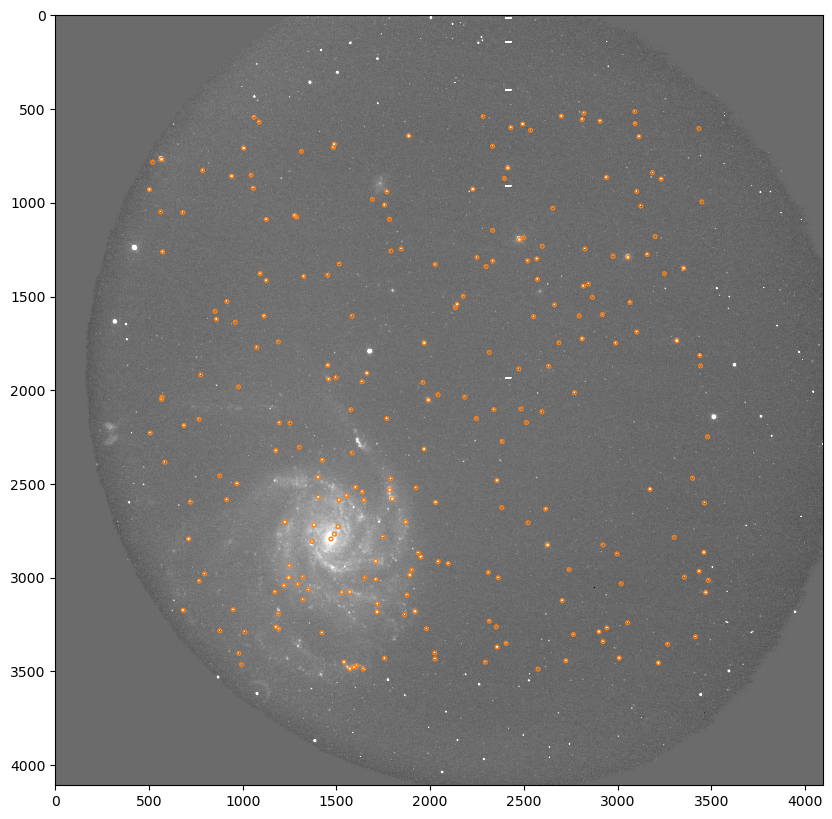

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 10, edgecolor='C1', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)
plt.show()

Executing command: psfex -c psfex_conf.psfex 20230525190514-248-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



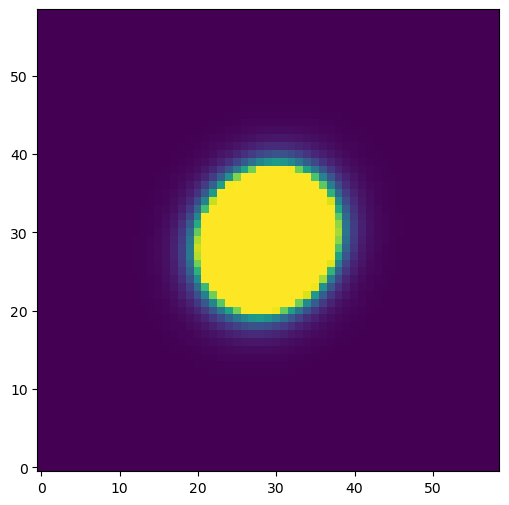

In [22]:
psfConfigFile = 'psfex_conf.psfex'

try:
    command = f'psfex -c {psfConfigFile} {catalogName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run psfex with exit error {err}')

psfModelHDU = fits.open('moffat_' + imageName + '.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)

plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std, origin='lower')
plt.show()

In [23]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' # This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
try:
    # We are supplying SExtactor with the PSF model with the PSF_NAME option
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {psfcatalogName} -PSF_NAME {psfName} -PARAMETERS_NAME {psfparamName}'
    print(f"Executing command: {command}")
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230525190514-248-RA.wcs.proc.fits -CATALOG_NAME 20230525190514-248-RA.wcs.proc.fits.psf.cat -PSF_NAME 20230525190514-248-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2024-06-24 at 21:54:32 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525190514-248-RA.wcs.proc.fits
----- Measuring from: 20230525190514-248-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1.92124    RMS: 11.2078    / Threshold: 112.078    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextr

In [24]:
with fits.open(psfcatalogName) as HDU:
    psfsourceTable = Table(HDU[2].data)

print(psfsourceTable.colnames)
print(psfsourceTable)

cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
         VIGNET           X_IMAGE  ... FLUXRATIOERR_POINTSOURCE
------------------------ --------- ... ------------------------
 15.067861 .. -5.2337313 2005.2853 ...                      0.0
0.09105396 .. -20.331797  2417.497 ...                      0.0
     -1e+30 .. -9.054135 2808.9968 ...                      0.0
-4.1701117 .. -24.300844  2121.072 ...                      0.0
    6.3693223 .. 3.22013 2162.2148 ...                      0.0
 -12.592602 .. -18.29984 1740.9592 ...                      0.0

Found 126 good cross-matches


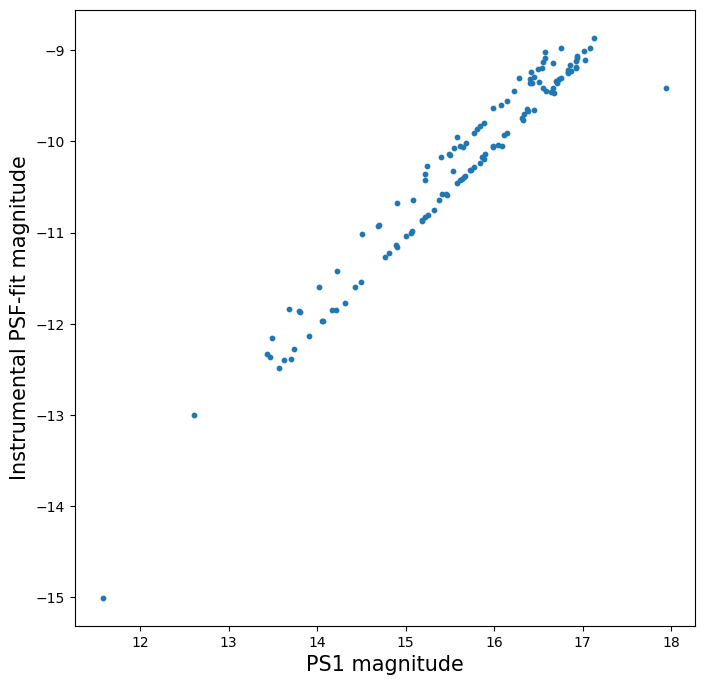

PSF Mean ZP: 25.91
PSF Median ZP: 26.03
PSF STD ZP: 0.20


/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [25]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print(f'Found {len(idx_psfimage)} good cross-matches')

plt.figure(figsize=(8,8))
plt.scatter(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage], color='C0', s=10)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

In [26]:
ra = 210.910674637
dec = 54.3116510708

sn2023ixf_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_sn2023ixf, idx_cleanpsf_sn2023ixf, d2d, d3d = psfsourceCatCoords.search_around_sky(sn2023ixf_coords, photoDistThresh*u.arcsec)
print(f'Found the source at index {idx_cleanpsf_sn2023ixf[0]}')

sn2023ixf_psfinstmag = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAG_POINTSOURCE'][0]
sn2023ixf_psfinstmagerr = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAGERR_POINTSOURCE'][0]

sn2023ixf_psfmag = zero_psfmed + sn2023ixf_psfinstmag
sn2023ixf_psfmagerr = np.sqrt(sn2023ixf_psfinstmagerr**2 + zero_psfstd**2)

print(f'PSF-fit magnitude of SN2023ixf is {sn2023ixf_psfmag} +/- {sn2023ixf_psfmagerr}')

Found the source at index 145
PSF-fit magnitude of SN2023ixf is 11.004573605346678 +/- 0.2041746119986295


# 20230525195322-030-RA.wcs.proc.fits

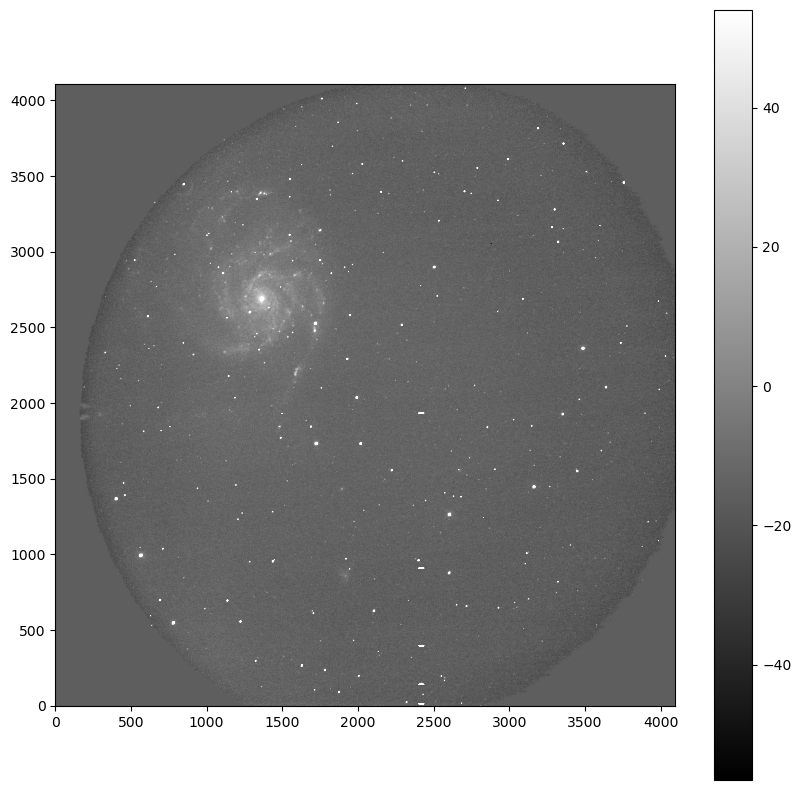


Querying Vizier II/349 around RA 211.0993, Dec 54.3123 with a radius of 30 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
210.729459870  53.862978240 172632107294506278 ... 15.1832  0.0043 115000
210.663724090  53.919290610 172702106637313866 ... 16.4559  0.0164 115000
210.663539540  53.892741500 172672106635471999 ... 16.3082  0.0166 115000
210.604486980  53.926405740 172712106044792397 ... 16.4376  0.0142 115000
210.625757450  53.949266840 172732106257949830 ... 13.8435  0.0035 115000
210.559704780  53.937696580 172722105596905934 ... 15.5672  0.0071 115000
210.439170920  54.003287860 172802104391914650 ... 14.9887  0.0043 115000
210.447712130  54.046944570 172852104477077040 ... 14.0260  0.0031 115000
210.394009680  54.069378840 172882103939893987 ... 15.2874  0.0041 115000
210.377594030  54.093628720 1

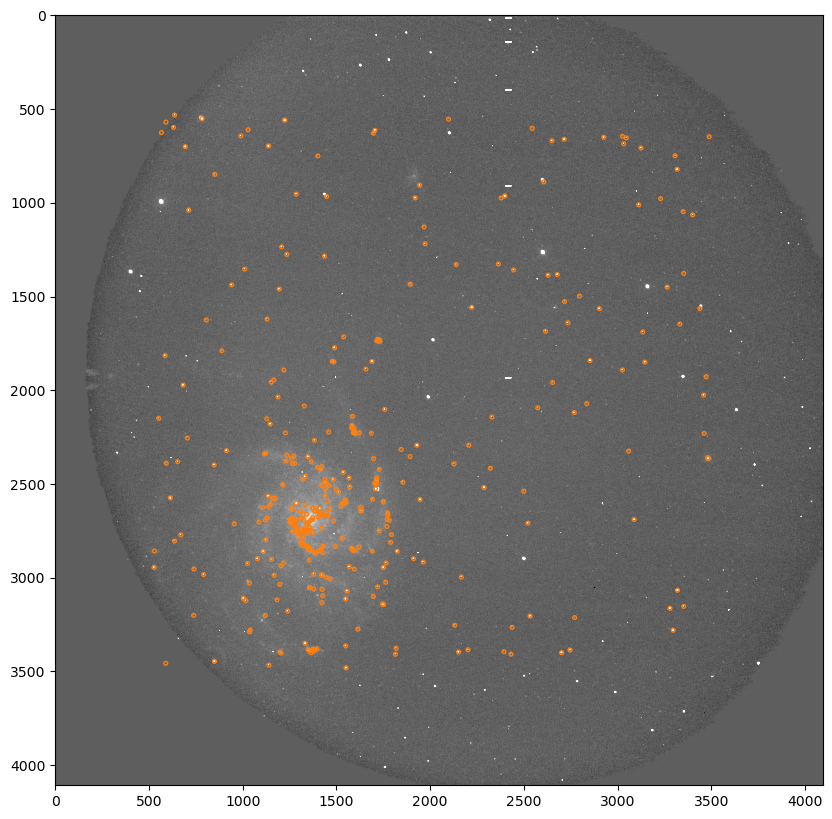

In [27]:
# os.chdir('/home/welcome/KSP/photometry/files_TASK_2')
imageName = '20230525195322-030-RA.wcs.proc.fits'

with fits.open(imageName) as HDUList:
    header = HDUList[0].header
    image = HDUList[0].data

zscale = ZScaleInterval().get_limits(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray', origin='lower', vmin=zscale[0], vmax=zscale[1])
plt.colorbar()
plt.show()

w = WCS(header)
(raImage, decImage) = w.all_pix2world(image.shape[0]/2, image.shape[1]/2, 1)
boxsize = 30 # arcminutes
maxmag = 18

catNum = 'II/349'
print(f'\nQuerying Vizier {catNum} around RA {raImage:.4f}, Dec {decImage:.4f} with a radius of {boxsize} arcmin')

try:
    # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":f"<{maxmag}", "Nd":">6", "e_gmag":f"<{1.086/3}"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=str(boxsize)+'m', catalog=catNum, cache=False)
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')

Q[0].meta['desc'] = Q[0].meta.pop('description')
Q[0].write('ps1Catalog-2.fits', format='fits', overwrite=True)

ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 10, edgecolor='C1', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

In [28]:
configFile = 'photomCat.sex'
catalogName = imageName + '.cat'
paramName = 'photomCat.param'
try:
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {catalogName} -PARAMETERS_NAME {paramName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230525195322-030-RA.wcs.proc.fits -CATALOG_NAME 20230525195322-030-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2024-06-24 at 21:58:41 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525195322-030-RA.wcs.proc.fits
----- Measuring from: 20230525195322-030-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -15.5859   RMS: 11.1514    / Threshold: 111.514    
> Scanning image
> Line:   25  Objects:        3 detected /        0 sextracted
> Line:   50  Objects:        4 detected /        0 sextracted
> Line:   75  Objects:        4 detected /        0 sextracted
> Line:  100

In [29]:
with fits.open(catalogName) as HDU:
    print(HDU.info())
    sourceTable = Table(HDU[2].data)

print(sourceTable.colnames)
print(sourceTable)

cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) & (sourceTable['YWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']>500)]

Filename: 20230525195322-030-RA.wcs.proc.fits.cat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [19040A]   
  2  LDAC_OBJECTS    1 BinTableHDU    106   256R x 25C   [729E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 10E, 10E, 10E, 10E]   
None
['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
         VIGNET           X_IMAGE  ...          MAGERR_APER          
------------------------ --------- ... ------------------------------
  18.597013 .. 56.834564 2319.2073 ...    0.004083268 .. 0.0054052295
-2.9596043 .. -2.5470085 2682.2734 ...      

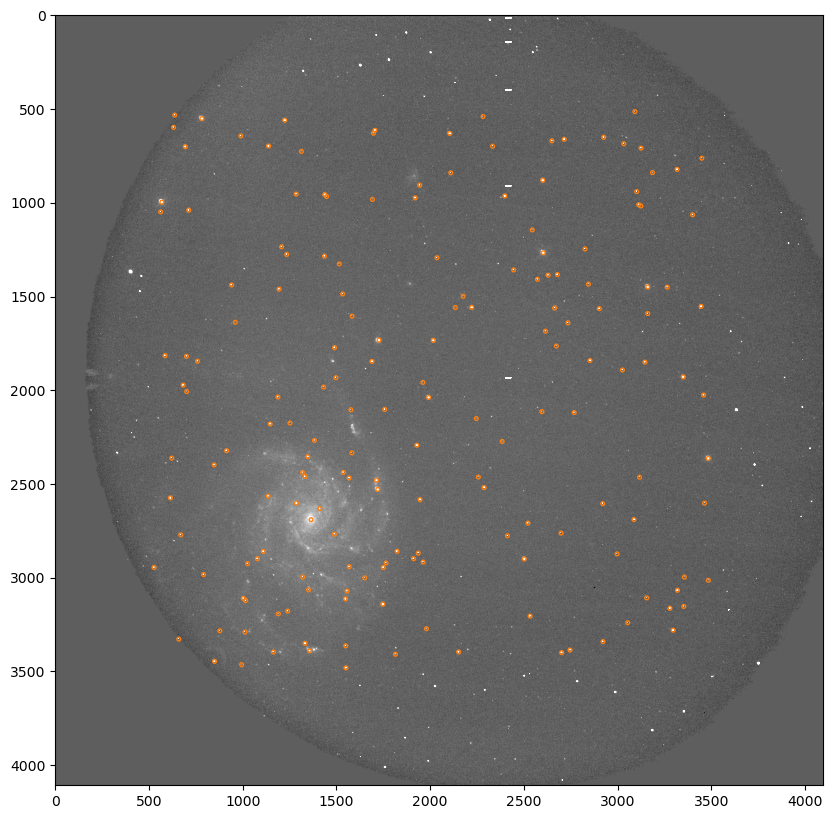

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 10, edgecolor='C1', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)
plt.show()

Executing command: psfex -c psfex_conf.psfex 20230525195322-030-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



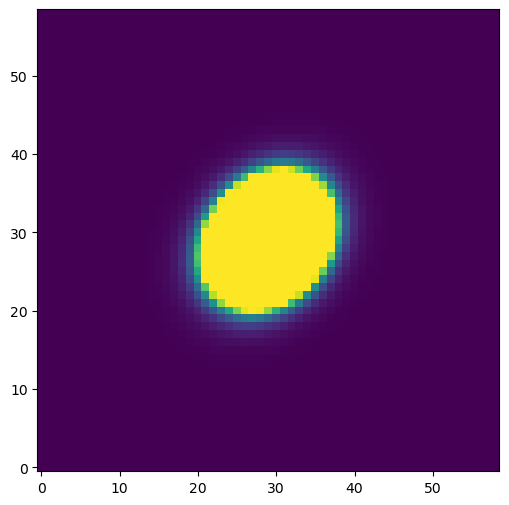

In [31]:
psfConfigFile = 'psfex_conf.psfex'

try:
    command = f'psfex -c {psfConfigFile} {catalogName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run psfex with exit error {err}')

psfModelHDU = fits.open('moffat_' + imageName + '.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)

plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std, origin='lower')
plt.show()

In [32]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' # This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
try:
    # We are supplying SExtactor with the PSF model with the PSF_NAME option
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {psfcatalogName} -PSF_NAME {psfName} -PARAMETERS_NAME {psfparamName}'
    print(f"Executing command: {command}")
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230525195322-030-RA.wcs.proc.fits -CATALOG_NAME 20230525195322-030-RA.wcs.proc.fits.psf.cat -PSF_NAME 20230525195322-030-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2024-06-24 at 21:59:27 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525195322-030-RA.wcs.proc.fits
----- Measuring from: 20230525195322-030-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -15.5859   RMS: 11.1514    / Threshold: 111.514    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextr

In [33]:
with fits.open(psfcatalogName) as HDU:
    psfsourceTable = Table(HDU[2].data)

print(psfsourceTable.colnames)
print(psfsourceTable)

cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
         VIGNET           X_IMAGE  ... FLUXRATIOERR_POINTSOURCE
------------------------ --------- ... ------------------------
  18.597013 .. 56.834564 2319.2073 ...                      0.0
-2.9596043 .. -2.5470085 2682.2734 ...                      0.0
  -3.07975 .. -28.711325 2417.4966 ...                      0.0
     -1e+30 .. 4.5462284 2809.0017 ...                      0.0
-14.382771 .. -11.262213  2428.379 ...                      0.0
 -7.3432655 .. 7.9799213 1874.1138 ...                      0.0

Found 93 good cross-matches


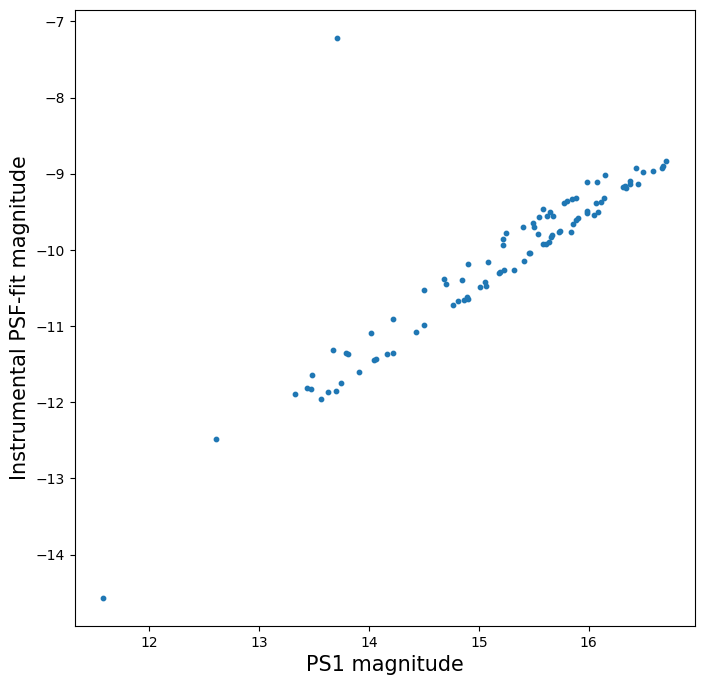

PSF Mean ZP: 25.37
PSF Median ZP: 25.48
PSF STD ZP: 0.19


/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/divyansh/miniforge3/envs/KSP/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [34]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print(f'Found {len(idx_psfimage)} good cross-matches')

plt.figure(figsize=(8,8))
plt.scatter(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage], color='C0', s=10)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

In [35]:
ra = 210.910674637
dec = 54.3116510708

sn2023ixf_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_sn2023ixf, idx_cleanpsf_sn2023ixf, d2d, d3d = psfsourceCatCoords.search_around_sky(sn2023ixf_coords, photoDistThresh*u.arcsec)
print(f'Found the source at index {idx_cleanpsf_sn2023ixf[0]}')

sn2023ixf_psfinstmag = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAG_POINTSOURCE'][0]
sn2023ixf_psfinstmagerr = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAGERR_POINTSOURCE'][0]

sn2023ixf_psfmag = zero_psfmed + sn2023ixf_psfinstmag
sn2023ixf_psfmagerr = np.sqrt(sn2023ixf_psfinstmagerr**2 + zero_psfstd**2)

print(f'PSF-fit magnitude of SN2023ixf is {sn2023ixf_psfmag} +/- {sn2023ixf_psfmagerr}')

Found the source at index 109
PSF-fit magnitude of SN2023ixf is 10.961072373962402 +/- 0.18584493456053353
